In [47]:
import numpy as np
import pandas as pd
import torch
import os
import torch.optim as optim
import torch.nn as nn
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt 

In [ ]:
# dataset :https://www.kaggle.com/datasets/CooperUnion/anime-recommendations-database?select=anime.csv

In [2]:
os.listdir("/kaggle/input/anime-recommendations-database")

['rating.csv', 'anime.csv']

In [159]:
device ="cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [126]:
rating=pd.read_csv("/kaggle/input/anime-recommendations-database/rating.csv")
anime=pd.read_csv("/kaggle/input/anime-recommendations-database/anime.csv")

In [127]:
anime.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


In [128]:
rating.head()

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


In [129]:
print(f"anime shape {anime.shape}")
print(f"rating shape {rating.shape}")

anime shape (12294, 7)
rating shape (7813737, 3)


In [130]:
rating=rating.sample(n=100000,random_state=42)

In [131]:
# for i in range (len(rating)):
rating.sort_values(["user_id","anime_id"])

,user_id,anime_id,rating
122,1,21881,-1
511,5,8841,5
622,5,15809,7
885,7,5233,8
887,7,5667,7
...,...,...,...
7812894,73503,22777,6
7812924,73503,30123,6
7813116,73507,355,4
7813168,73507,1818,8


In [132]:
# number of anime
len(anime.anime_id.unique())

12294

In [133]:
#number of intercated anime anime
len(rating.anime_id.unique())

5759

In [134]:
#number of user
len(rating.user_id.unique())

37838

In [135]:
rating.anime_id.max()

34240

In [14]:
# pivot_tabel=rating.pivot_table(index="anime_id",columns="user_id",values="rating")

In [136]:
#unrated anime
unique_rating=rating.groupby("anime_id").rating.unique()
unrated_anime=unique_rating[unique_rating.apply(lambda x: len(x)==1 and x[0]==-1)]
len(unrated_anime)

440

In [137]:
#remove unrated anime
rating=rating[rating.anime_id.apply(lambda x: x not in unrated_anime.index )]

In [138]:
len(rating.anime_id.unique())

5319

In [139]:
# user with no rating
unique_user_wrating=rating.groupby("user_id").rating.unique()
user_without_rating=unique_user_wrating[unique_user_wrating.apply(lambda x: len(x)==1 and x[0]==-1)]
len(user_without_rating)

5487

In [140]:
rating=rating[rating.user_id.apply(lambda x: x not in user_without_rating.index )]

In [141]:
len(rating.user_id.unique())

32318

In [142]:
# diffrent rating
rating.rating.value_counts()

rating
 8     20936
 7     17595
 9     16006
 10    12382
 6      8188
-1      5847
 5      3631
 4      1299
 3       496
 2       284
 1       239
Name: count, dtype: int64

In [196]:
anime_weights=torch.rand((len(rating.anime_id.unique()),100),requires_grad=True,dtype=torch.float,device=device)
user_weights=torch.rand((len(rating.user_id.unique()),100),requires_grad=True,dtype=torch.float,device=device)
bias=torch.rand((len(rating.user_id.unique()),1),requires_grad=True,dtype=torch.float,device=device)

In [144]:
print(f"w shape {user_weights.shape}")
print(f"x shape {anime_weights.shape}")
print(f"bias shape {bias.shape}")

w shape torch.Size([32318, 100])
x shape torch.Size([5319, 100])
bias shape torch.Size([32318, 1])


In [24]:
anime_weights[0]

tensor([0.9149, 0.4724, 0.2441, 0.8657, 0.5116, 0.0470, 0.4916, 0.9125, 0.2138,
        0.2887, 0.7930, 0.7608, 0.5586, 0.3570, 0.2737, 0.7577, 0.2821, 0.2648,
        0.8044, 0.3187, 0.8973, 0.6591, 0.9598, 0.9540, 0.9215, 0.0381, 0.6592,
        0.2185, 0.9759, 0.7718, 0.4851, 0.5348, 0.6080, 0.8462, 0.5353, 0.1974,
        0.2970, 0.7146, 0.2517, 0.9367, 0.8557, 0.7744, 0.7566, 0.7685, 0.5131,
        0.9673, 0.0281, 0.6167, 0.7046, 0.3318, 0.0421, 0.5171, 0.4052, 0.6173,
        0.1778, 0.7913, 0.5098, 0.5962, 0.3899, 0.6181, 0.1766, 0.7611, 0.6429,
        0.9851, 0.1176, 0.4165, 0.3622, 0.1234, 0.9030, 0.9465, 0.4910, 0.9995,
        0.6813, 0.8153, 0.0640, 0.5535, 0.2995, 0.9468, 0.6843, 0.7402, 0.0064,
        0.3855, 0.0979, 0.5941, 0.0633, 0.8136, 0.2020, 0.8172, 0.5942, 0.5729,
        0.0138, 0.9814, 0.9370, 0.7410, 0.2992, 0.7417, 0.7736, 0.3806, 0.6188,
        0.7770], device='cuda:0', grad_fn=<SelectBackward0>)

In [145]:
anime_map=rating.anime_id.unique()
anime_map.sort()
anime_map

array([    1,     5,     6, ..., 34085, 34103, 34240])

In [146]:
user_map=rating.user_id.unique()
user_map.sort()
user_map

array([    5,     7,    11, ..., 73503, 73507, 73515])

In [147]:
rating=rating.sort_values(["user_id","anime_id"])

In [148]:
rating

,user_id,anime_id,rating
511,5,8841,5
622,5,15809,7
885,7,5233,8
887,7,5667,7
941,7,11977,8
...,...,...,...
7812894,73503,22777,6
7812924,73503,30123,6
7813116,73507,355,4
7813168,73507,1818,8


In [149]:
pivot_matrix=rating.pivot_table(index="user_id",columns="anime_id",values="rating")

In [166]:
pivot_matrix=pivot_matrix.fillna(0)
pivot_matrix=pivot_matrix.replace(-1,0)

In [167]:
Y=torch.tensor(np.array(pivot_matrix),dtype=torch.float,device=device)

In [168]:
Y.shape


torch.Size([32318, 5319])

In [169]:
mask=Y!=0

In [177]:
mask=mask.type(torch.int)
sum_rating=torch.sum(Y*mask,dim=0)
num_rating=torch.sum(mask,dim=0)

In [180]:
mean=sum_rating/num_rating

In [183]:
Y_mean=Y-mean

In [185]:
Y_mean.shape

torch.Size([32318, 5319])

In [197]:
optimizer=optim.Adam([anime_weights,user_weights,bias],lr=0.01)

epochs=100

lmba=1

loss_list=[]
for epoch in tqdm(range(epochs)):

  j =(torch.mm(user_weights,anime_weights.t())+bias)-Y_mean
  j=0.5*torch.sum(j**2)+(torch.sum(user_weights**2)+torch.sum(anime_weights**2))*(lmba)/2

  loss_list.append(j.item())
  optimizer.zero_grad()
  j.backward()
  optimizer.step()




100%|██████████| 100/100 [00:04<00:00, 21.57it/s]


In [106]:
# optimizer=optim.Adam([anime_weights,user_weights,bias],lr=0.01)
# criterion = nn.MSELoss()
# epochs=20

# lmba=1

# loss_list=[]
# for epoch in tqdm(range(epochs)):
#   loss=0
#   regu=0
#   for rate in rating.itertuples():
#     if rate.rating!=-1:
#       target =torch.tensor([rate.rating],dtype=torch.float).unsqueeze(1).to(device)
#       loss+=criterion(torch.mm(user_weights[np.where(user_map==rate.user_id)],anime_weights[np.where(anime_map==rate.anime_id)].t())+bias[np.where(user_map==rate.user_id)],target)/2
#   for x in anime_weights:
#     for i in x:
#       regu+=i**2
#   for w in user_weights:
#     for i in w:
#       regu+=i**2
#   regu=regu*(lmba/2)
#   loss+=regu
#   loss_list.append(loss.item())
#   optimizer.zero_grad()
#   loss.backward()
#   optimizer.step()




100%|██████████| 20/20 [1:58:00<00:00, 354.01s/it]


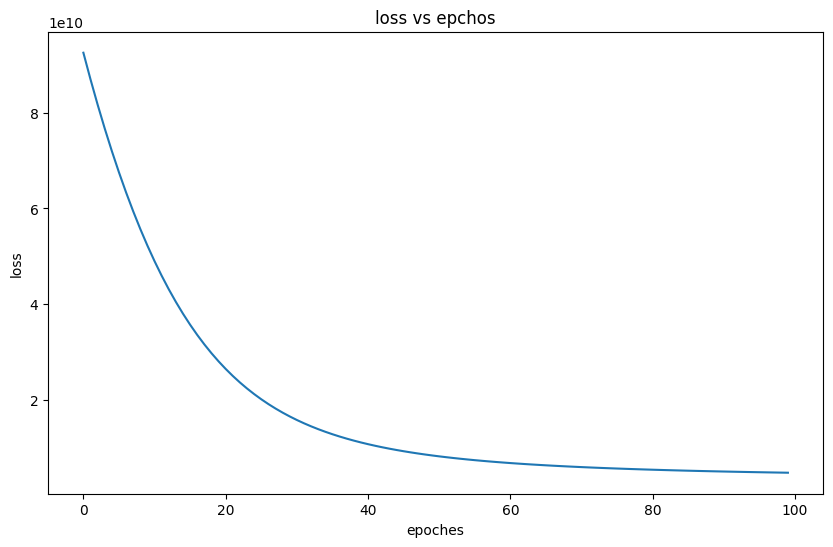

In [198]:
plt.figure(figsize=[10,6])
plt.plot(loss_list)
plt.title("loss vs epchos")
plt.xlabel("epoches")
plt.ylabel("loss")
plt.show()

In [28]:
# criterion(torch.mm(user_weights[np.where(user_map==rate.user_id)],anime_weights[np.where(anime_map==rate.anime_id)].t())+bias[np.where(user_map==rate.user_id)],torch.tensor([rate.rating]).unsqueeze(1))/2

In [199]:
with torch.no_grad():
    weight_list=anime_weights.to("cpu").numpy()
similarty=cosine_similarity(weight_list)

In [200]:

anime_name=input("enter the name of the anime : ")
id=anime[anime.name==anime_name].anime_id.values[0]
anime_similarty=list(enumerate(similarty[np.where(anime_map==id)].reshape(-1,)))
anime_similarty=sorted(anime_similarty,key=lambda x : x[1], reverse=True)
names_list=[]
for i in range(10):
    anime_idx,score=anime_similarty[i]
    anime_id=anime_map[anime_idx]
    anime_name=anime[anime.anime_id==anime_id].name.values[0]
    names_list.append((anime_name,score))
  







enter the name of the anime :  Gintama°


In [201]:
names_list

[('Gintama°', 1.0000001),
 ('Tono to Issho: Ippunkan Gekijou', 0.39085388),
 ('Victorian Maid Maria no Houshi', 0.37657735),
 ('Yakin Byoutou', 0.36640668),
 ('Senjou no Valkyria: SenVal Theater', 0.3535963),
 ('Strike Witches OVA', 0.3353241),
 ('Xenosaga The Animation', 0.3284101),
 ('Marmalade Boy', 0.32693428),
 ('Ongaku Shoujo', 0.32459006),
 ('Sukeban Deka', 0.3226186)]

## we can see that in the case of similarty between content is not good 

In [115]:
#in case of rating predection 
with torch.no_grad():
    predection =torch.mm(user_weights,anime_weights.t())+bias

In [116]:
predection

tensor([[13.0419, 12.4569, 14.0773,  ..., 11.7457, 12.1961, 13.7817],
        [10.4265, 10.7871, 12.4125,  ..., 10.6853, 10.6524, 11.4868],
        [11.5762, 11.4750, 14.6787,  ...,  9.6929, 11.3984, 11.8504],
        ...,
        [11.7969, 11.6241, 13.2636,  ..., 10.4271, 12.4077, 11.2204],
        [12.9784, 11.8641, 13.2711,  ...,  9.4333, 12.0492, 12.6030],
        [ 9.9725,  9.6940, 10.4043,  ...,  8.9697,  9.6516,  9.8708]],
       device='cuda:0')

In [99]:
bias

tensor([[-0.1790],
        [ 0.2970],
        [-0.0584],
        ...,
        [ 0.4172],
        [ 0.7889],
        [ 0.7874]], device='cuda:0', requires_grad=True)

In [213]:
with torch.no_grad():
      predection =(torch.mm(user_weights,anime_weights.t())+bias)+mean
      

In [235]:
Y[1,Y[1]!=0]

tensor([8., 7., 8., 7.], device='cuda:0')

In [236]:
predection[1,Y[1]!=0]

tensor([8.2332, 6.9684, 8.3006, 8.6349], device='cuda:0')

## in term of user predection we can see that colaborative filltring give a good result 